# Algos de Machine Learning

## ARIMA

In [193]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import ta

In [194]:
apple_df = pd.read_csv("datas/apple_data.csv")
apple_df.head()

,date,open,high,low,close,volume
0,2010-01-04,7.62,7.66,7.58,7.64,493729600
1,2010-01-05,7.66,7.70,7.62,7.66,601904800
2,2010-01-06,7.66,7.69,7.53,7.53,552160000
3,2010-01-07,7.56,7.57,7.47,7.52,477131200
4,2010-01-08,7.51,7.57,7.47,7.57,447876740


- Rendre la série stationnaire avec une différenciation d'ordre 1 : stabiliser la moyenne + enlever la tendance

In [195]:
close_apple = apple_df['close']

In [196]:
close_apple_diff = close_apple.diff().dropna()

result_diff = adfuller(close_apple_diff)
print(f"Statistique ADF (diff) : {result_diff[0]}")
print(f"Valeur p (diff) : {result_diff[1]}")

Statistique ADF (diff) : -11.351503674577929
Valeur p (diff) : 9.968907474361587e-21


Split temporel :

In [197]:
train_size = int(len(close_apple) * 0.8)
train_arima = close_apple[:train_size]
test_arima = close_apple[train_size:]

explication pour order=(2, 1, 2) 
- p=2 : 2 termes autorégressifs (AR)
- d=1 : 1 différenciation (=> stationnarisation)
- q=2 : 2 termes de moyenne mobile (MA)

In [198]:
model = ARIMA(train_arima, order=(2, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 3078
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4817.914
Date:                Thu, 24 Apr 2025   AIC                           9645.828
Time:                        11:15:46   BIC                           9675.986
Sample:                             0   HQIC                          9656.662
                               - 3078                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1712      0.475      0.361      0.718      -0.759       1.101
ar.L2          0.3088      0.156      1.978      0.048       0.003       0.615
ma.L1         -0.2153      0.474     -0.454      0.6

In [199]:
forecast = model_fit.forecast(steps=len(test_arima))
print("Prévision du cours du jour suivant :", forecast.iloc[0])
print(forecast)

Prévision du cours du jour suivant : 173.84062934612254
3078    173.840629
3079    173.828399
3080    173.755483
3081    173.739226
3082    173.713930
           ...    
3843    173.680936
3844    173.680936
3845    173.680936
3846    173.680936
3847    173.680936
Name: predicted_mean, Length: 770, dtype: float64


In [200]:
mse = mean_squared_error(test_arima, forecast)
rmse_arima = np.sqrt(mse)
print(f"RMSE Arima : {rmse_arima:.2f}")

RMSE Arima : 33.56


In [201]:
#erreur relative = % d'erreur moyen
mape_arima = np.mean(np.abs((test_arima - forecast) / test_arima)) * 100
print(f"MAPE Arima : {mape_arima:.2f}%")

MAPE Arima : 13.93%


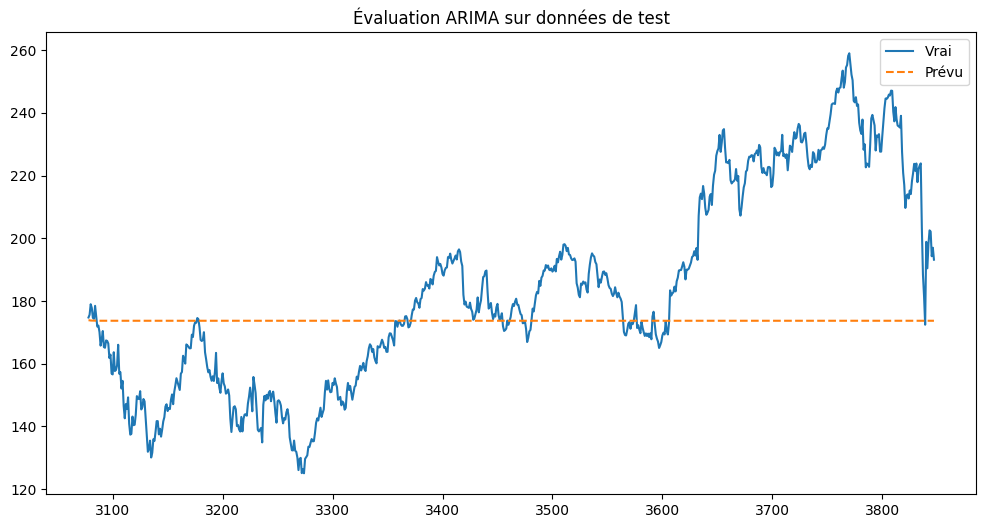

In [202]:
plt.figure(figsize=(12,6))
plt.plot(test_arima.index, test_arima, label='Vrai')
plt.plot(test_arima.index, forecast, label='Prévu', linestyle='--')
plt.legend()
plt.title("Évaluation ARIMA sur données de test")
plt.show()

# Random Forest

Baseline : à partir des données du jour-même

In [203]:
X = apple_df[['open', 'high', 'low', 'volume']]
y = apple_df['close']

In [204]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [205]:
X_train, X_test, y_train, y_test_rf = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

In [206]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [207]:
y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
r2_rf = r2_score(y_test_rf, y_pred_rf)

print(f"RMSE Random Forest : {rmse_rf:.2f}")
print(f"R² Random Forest : {r2_rf:.2f}")

RMSE Random Forest : 26.69
R² Random Forest : 0.31


### Feature engineering

- delta sur les cours 3j, 10j, 30j
- moyennes mobiles pour capturer les tendances
- RSI pour détecter les zones de surachat/survente
- les bandes de Bollinger pour capter la volatilité
- le MACD pour observer les changements de la vitesse de variation des prix

1 - Deltas

In [208]:
apple_df['delta_3j'] = (apple_df['close'] - apple_df['close'].shift(3)) / apple_df['close'].shift(3)
apple_df['delta_10j'] = (apple_df['close'] - apple_df['close'].shift(10)) / apple_df['close'].shift(10)
apple_df['delta_30j'] = (apple_df['close'] - apple_df['close'].shift(30)) / apple_df['close'].shift(30)

In [209]:
apple_df.isnull().sum()

date          0
open          0
high          0
low           0
close         0
volume        0
delta_3j      3
delta_10j    10
delta_30j    30
dtype: int64

In [210]:
apple_df = apple_df.dropna(subset=['delta_3j', 'delta_10j', 'delta_30j'])

In [211]:
X = apple_df.drop(columns=['date', 'close'])
y = apple_df['close']

In [212]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rf = r2_score(y_test, y_pred)
mae_rf = mean_absolute_error(y_test, y_pred)

print(f"RMSE Random Forest avec deltas : {rmse_rf:.2f}")
print(f"R² Random Forest avec deltas : {r2_rf:.2f}")
print(f"MAE Random Forest avec deltas : {mae_rf:.2f}")

RMSE Random Forest avec deltas : 26.92
R² Random Forest avec deltas : 0.30
MAE Random Forest avec deltas : 16.04


## GridSearchCV

Recherche de paramètres à optimiser pour la randomForest

In [214]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Meilleurs paramètres : ", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

rmse_grid_search = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"RMSE Random Forest après GridSearch : {rmse_grid_search:.2f}")

r2_grid_search = best_rf.score(X_test, y_test)
print(f"R² Random Forest après GridSearch : {r2_grid_search:.2f}")

mae_best = mean_absolute_error(y_test, y_pred_best)
print(f"MAE Random Forest après GridSearch : {mae_best:.2f}")

/var/www/html/cours/brief15_prediction_bourse/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
361 fits failed with the following error:
Traceback (most recent call last):
  File "/var/www/html/cours/brief15_prediction_bourse/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/var/www/html/cours/brief15_prediction_bourse/venv/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/var/www/html/cours/brief15_prediction_bourse/venv/lib/python3.

Meilleurs paramètres :  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RMSE Random Forest après GridSearch : 28.35
R² Random Forest après GridSearch : 0.22
MAE Random Forest après GridSearch : 17.44


Ajout des moyennes mobiles

In [215]:
apple_df['sma10'] = apple_df['close'].rolling(window=10).mean()
apple_df['sma30'] = apple_df['close'].rolling(window=30).mean()

Ajout RSI (Relative Strength Index)

In [216]:
rsi = ta.momentum.RSIIndicator(close=close_apple, window=14)
apple_df['rsi_14'] = rsi.rsi()

Ajout des bandes de Bollinger

In [217]:
bollinger = ta.volatility.BollingerBands(close=close_apple, window=20, window_dev=2)
apple_df['bollinger_mavg'] = bollinger.bollinger_mavg()
apple_df['bollinger_high'] = bollinger.bollinger_hband()
apple_df['bollinger_low'] = bollinger.bollinger_lband()

Ajout MACD

In [218]:
macd = ta.trend.MACD(close=close_apple)
apple_df['macd'] = macd.macd()
apple_df['macd_signal'] = macd.macd_signal()
apple_df['macd_diff'] = macd.macd_diff()

Création de la target et nettoyage des premières lignes Nan

In [219]:
apple_df['target'] = apple_df['close'].shift(-1)

In [220]:
apple_df.dropna(inplace=True)

## Réentraînement de la Random Forest

In [221]:
apple_df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'delta_3j',
       'delta_10j', 'delta_30j', 'sma10', 'sma30', 'rsi_14', 'bollinger_mavg',
       'bollinger_high', 'bollinger_low', 'macd', 'macd_signal', 'macd_diff',
       'target'],
      dtype='object')

In [222]:
features = ['open', 'high', 'low', 'volume',
            'delta_3j', 'delta_10j', 'delta_30j',
            'sma10', 'sma30', 'rsi_14',
            'bollinger_mavg', 'bollinger_high', 'bollinger_low',
            'macd', 'macd_signal', 'macd_diff']

In [223]:
X = apple_df[features]
y = apple_df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rf = r2_score(y_test, y_pred)
mae_rf = mean_absolute_error(y_test, y_pred)

print(f"RMSE Random Forest avec indicateurs : {rmse_rf:.2f}")
print(f"R² Random Forest avec indicateurs : {r2_rf:.2f}")
print(f"MAE Random Forest avec indicateurs : {mae_rf:.2f}")

RMSE Random Forest avec indicateurs : 30.43
R² Random Forest avec indicateurs : 0.11
MAE Random Forest avec indicateurs : 19.85


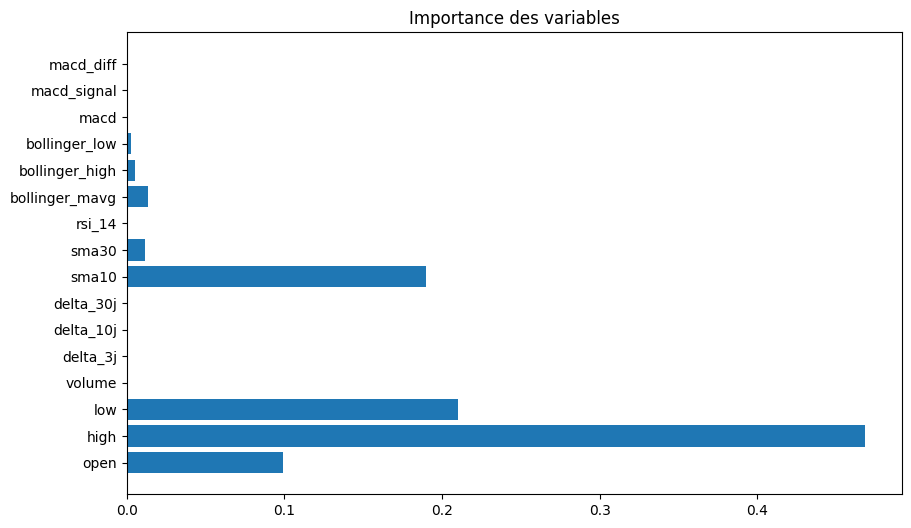

In [224]:
importances = rf_model.feature_importances_
feat_names = X.columns

plt.figure(figsize=(10,6))
plt.barh(feat_names, importances)
plt.title("Importance des variables")
plt.show()

In [225]:
features_reajusted = ['open', 'high', 'low', 'sma10', 'sma30', 'bollinger_mavg', 'bollinger_high', 'bollinger_low']

In [226]:
X = apple_df[features_reajusted]
y = apple_df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rf = r2_score(y_test, y_pred)
mae_rf = mean_absolute_error(y_test, y_pred)

print(f"RMSE Random Forest avec indicateurs : {rmse_rf:.2f}")
print(f"R² Random Forest avec indicateurs : {r2_rf:.2f}")
print(f"MAE Random Forest avec indicateurs : {mae_rf:.2f}")

RMSE Random Forest avec indicateurs : 29.06
R² Random Forest avec indicateurs : 0.19
MAE Random Forest avec indicateurs : 18.67


## Automatisation

In [227]:
def test_features(feature_list, df, target_col='target', test_size=0.2):
    X = df[feature_list].copy()
    y = df[target_col].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)

    y_pred_rf_indicators = rf_model.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return {'features': feature_list, 'RMSE': rmse, 'R2': r2, 'MAE': mae}

In [228]:
feature_sets = [
    ['open', 'high', 'low', 'sma10', 'sma30'],
    ['bollinger_mavg', 'bollinger_high', 'bollinger_low'],
    ['open', 'high', 'low', 'bollinger_mavg', 'bollinger_high', 'bollinger_low'],
    ['sma10', 'sma30'],
    ['open', 'high', 'low'],
    ['open', 'high', 'low', 'bollinger_mavg', 'bollinger_high', 'bollinger_low', 'sma10', 'sma30']
]

results = []
for features in feature_sets:
    result = test_features(features, apple_df)
    results.append(result)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='RMSE')
print(results_df)

                                            features       RMSE        R2  \
0                    [open, high, low, sma10, sma30]  29.055869  0.190895   
1    [bollinger_mavg, bollinger_high, bollinger_low]  29.055869  0.190895   
2  [open, high, low, bollinger_mavg, bollinger_hi...  29.055869  0.190895   
3                                     [sma10, sma30]  29.055869  0.190895   
4                                  [open, high, low]  29.055869  0.190895   
5  [open, high, low, bollinger_mavg, bollinger_hi...  29.055869  0.190895   

         MAE  
0  18.668843  
1  18.668843  
2  18.668843  
3  18.668843  
4  18.668843  
5  18.668843  


Analyse :

1 - Combinaison de prix et indicateurs techniques : Les meilleurs résultats sont obtenus en combinant les prix (open, high, low) avec des indicateurs techniques comme les bandes de Bollinger. Ces derniers ajoutent un signal utile en complément, mais ne suffisent pas seuls.

2 - Les prix seuls : Utiliser uniquement les prix (open, high, low) donne des résultats presque aussi bons que ceux avec les bandes de Bollinger ajoutées. Les prix sont donc très informatifs à eux seuls.

3 - Moyennes mobiles (sma10/sma30) : Ces indicateurs, pris isolément, sont peu utiles. Ils lissent trop les données, ce qui masque les variations immédiates importantes.

4 - Bandes de Bollinger seules : Elles sont inefficaces sans le contexte des prix bruts, probablement parce qu'elles dépendent fortement de la moyenne et de l’écart-type.

In [229]:
X = apple_df[['open', 'high', 'low', 'bollinger_mavg', 'bollinger_high', 'bollinger_low']]
y = apple_df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf_indicator = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf_indicator))
r2_rf = r2_score(y_test, y_pred_rf_indicator)
mae_rf = mean_absolute_error(y_test, y_pred_rf_indicator)

print(f"RMSE Random Forest avec indicateurs : {rmse_rf:.2f}")
print(f"R² Random Forest avec indicateurs : {r2_rf:.2f}")
print(f"MAE Random Forest avec indicateurs : {mae_rf:.2f}")

RMSE Random Forest avec indicateurs : 28.41
R² Random Forest avec indicateurs : 0.23
MAE Random Forest avec indicateurs : 18.08


# Visualisation

In [230]:
forecast_index = test_arima.index 
forecast_series = pd.Series(forecast, index=forecast_index)

In [231]:
print(y_test_rf.shape)
print(y_pred_rf.shape)

(770,)
(770,)


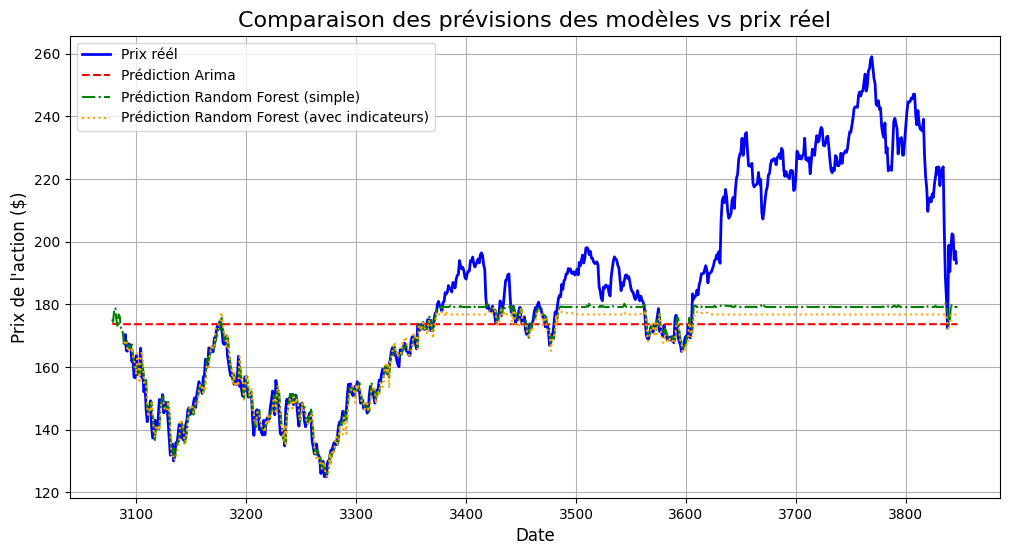

In [232]:
plt.figure(figsize=(12, 6))

plt.plot(y_test.index, y_test, label='Prix réél', color='blue', linewidth=2)
plt.plot(forecast_series.index, forecast_series, label='Prédiction Arima', color='red', linestyle='--')
plt.plot(y_test_rf.index, y_pred_rf, label='Prédiction Random Forest (simple)', color='green', linestyle='-.')
plt.plot(y_test.index, y_pred_rf_indicator, label='Prédiction Random Forest (avec indicateurs)', color='orange', linestyle=':')

plt.title('Comparaison des prévisions des modèles vs prix réel', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Prix de l\'action ($)', fontsize=12)
plt.legend()

plt.grid(True)
plt.show()